## PLOT NIO

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
companies = data['Stock Name'].unique()
data = data.sort_values(by=['Stock Name', 'Date'])

#data.drop(columns=['Stock Name'], inplace=True)
# data.drop(columns=['MA20'], inplace=True)
# data.drop(columns=['logmomentum'], inplace=True)
# data.drop(columns=['20SD'], inplace=True)
# data.drop(columns=['MA7'], inplace=True)
# data.drop(columns=['MACD'], inplace=True)
# data.drop(columns=['upper_band'], inplace=True)
# data.drop(columns=['lower_band'], inplace=True)
# data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train (7 companies) and test (1 company)
train_data = data[data['Stock Name'] != companies[-1]]
test_data = data[data['Stock Name'] == companies[-1]]

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


2025-01-29 19:33:36.111807: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-01-29 19:33:36.309632: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-29 19:33:37.303683: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/lib:/usr/local/nvidia/lib:/usr/local/nvidia/lib64
2025-01-29 19:33:37.303805

Epoch 1/100


2025-01-29 19:33:44.893865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8400
2025-01-29 19:33:45.468337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:630] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


49/49 [==============================] - 8s 29ms/step - loss: 0.0140 - val_loss: 0.0031
Epoch 2/100
49/49 [==============================] - 1s 11ms/step - loss: 0.0023 - val_loss: 0.0013
Epoch 3/100
49/49 [==============================] - 1s 20ms/step - loss: 0.0013 - val_loss: 3.2514e-04
Epoch 4/100
49/49 [==============================] - 1s 12ms/step - loss: 9.4855e-04 - val_loss: 1.2871e-04
Epoch 5/100
49/49 [==============================] - 1s 19ms/step - loss: 8.8925e-04 - val_loss: 1.0780e-04
Epoch 6/100
49/49 [==============================] - 1s 12ms/step - loss: 7.9769e-04 - val_loss: 7.0875e-05
Epoch 7/100
49/49 [==============================] - 1s 22ms/step - loss: 7.9065e-04 - val_loss: 6.8630e-05
Epoch 8/100
49/49 [==============================] - 1s 12ms/step - loss: 7.6977e-04 - val_loss: 1.7185e-04
Epoch 9/100
49/49 [==============================] - 1s 19ms/step - loss: 7.8282e-04 - val_loss: 4.6978e-04
Epoch 10/100
49/49 [==============================] - 1s 11m

NameError: name 'mean_absolute_error' is not defined

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
companies = data['Stock Name'].unique()
data = data.sort_values(by=['Stock Name', 'Date'])

#data.drop(columns=['Stock Name'], inplace=True)
data.drop(columns=['MA20'], inplace=True)
data.drop(columns=['logmomentum'], inplace=True)
data.drop(columns=['20SD'], inplace=True)
data.drop(columns=['MA7'], inplace=True)
data.drop(columns=['MACD'], inplace=True)
data.drop(columns=['upper_band'], inplace=True)
data.drop(columns=['lower_band'], inplace=True)
data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train (7 companies) and test (1 company)
train_data = data[data['Stock Name'] != companies[-1]]
test_data = data[data['Stock Name'] == companies[-1]]

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 100
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()

## PLOT AAPL

In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
data = data.sort_values(by=['Stock Name', 'Date'])
companies = data['Stock Name'].unique()

#Let's drop indexes as are not needed in a time series model
data.drop(columns=['MA20'], inplace=True)
data.drop(columns=['logmomentum'], inplace=True)
data.drop(columns=['20SD'], inplace=True)
data.drop(columns=['MA7'], inplace=True)
data.drop(columns=['MACD'], inplace=True)
data.drop(columns=['upper_band'], inplace=True)
data.drop(columns=['lower_band'], inplace=True)
data.drop(columns=['EMA'], inplace=True)

# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Check for remaining NaNs
if data.isna().sum().sum() > 0:
    print("Warning: There are still NaN values in the dataset!")

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split into train and test datasets
test_data = data.iloc[:252]  # First 252 rows for testing
train_data = data.iloc[252:]  # Remaining rows for training

# Prepare training sequences
def create_sequences(df, target_column, sequence_length=30):
    X, y = [], []
    data_values = df.drop(columns=['Stock Name', 'Date', target_column]).values
    target_values = df[target_column].values
    for i in range(len(df) - sequence_length):
        X.append(data_values[i:i+sequence_length])
        y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # Number of time steps
X_train, y_train = create_sequences(train_data, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences(test_data, target_column='Close', sequence_length=sequence_length)

# Build the GRU model
model = Sequential([
    GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
    Dense(32, activation='relu'),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')

# Train the model
epochs = 50
batch_size = 32
model.fit(X_train, y_train, validation_split=0.1, epochs=epochs, batch_size=batch_size, verbose=1)

# Predictions
predictions = model.predict(X_test)

# Inverse scale the predictions and ground truth
predictions_rescaled = scaler_close.inverse_transform(predictions)
y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

# Calculate evaluation metrics
mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
rmse = np.sqrt(mse)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

# Plot predictions vs true values
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Original Scale)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
stock_names = data['Stock Name'].unique()
print(stock_names)


## PLOT AMAZON

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Stock Name',
       'Z_Score_Normalized', 'MA7', 'MA20', 'MACD', '20SD', 'upper_band',
       'lower_band', 'EMA', 'logmomentum'],
      dtype='object')
Epoch 1/250
44/44 [==============================] - 3s 22ms/step - loss: 0.0192 - val_loss: 0.0035
Epoch 2/250
44/44 [==============================] - 1s 12ms/step - loss: 0.0092 - val_loss: 3.4653e-04
Epoch 3/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0024 - val_loss: 1.0352e-04
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0047 - val_loss: 0.0039
Epoch 5/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0014 - val_loss: 2.1931e-04
Epoch 6/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0014
Epoch 7/250
44/44 [==============================] - 1s 14ms/step - loss: 9.4917e-04 - val_loss: 4.9160e-04
Epoch 8/250
44/44 [==============================] - 1s 13ms/step - l

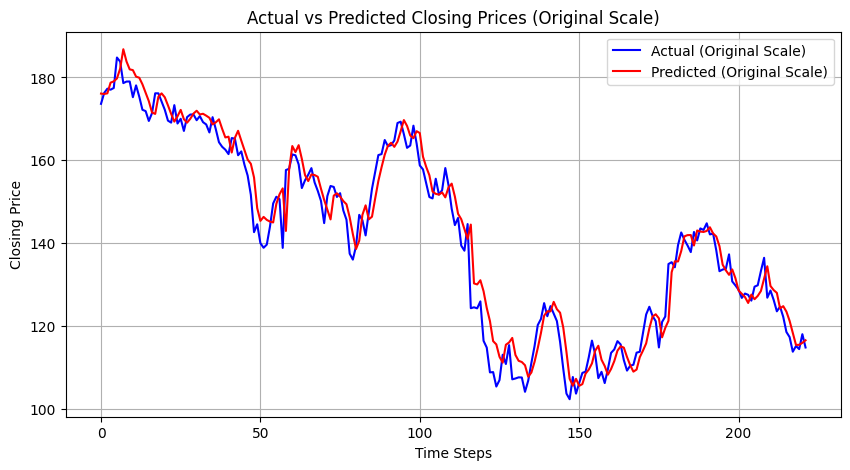

Epoch 1/250
44/44 [==============================] - 3s 24ms/step - loss: 0.0164 - val_loss: 0.0052
Epoch 2/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 2.3868e-04
Epoch 3/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0047 - val_loss: 6.6562e-04
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0040 - val_loss: 2.6930e-04
Epoch 5/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0013 - val_loss: 8.8310e-04
Epoch 6/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0017 - val_loss: 2.1635e-04
Epoch 7/250
44/44 [==============================] - 1s 14ms/step - loss: 8.6110e-04 - val_loss: 4.0567e-04
Epoch 8/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 1.8478e-04
Epoch 9/250
44/44 [==============================] - 1s 14ms/step - loss: 7.7107e-04 - val_loss: 1.9375e-04
Epoch 10/250
44/44 [==============================] - 1s 14m

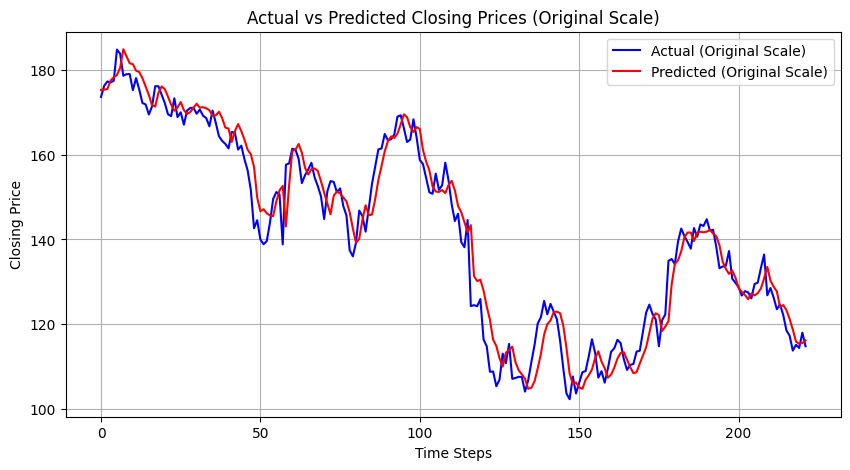

Epoch 1/250
44/44 [==============================] - 3s 22ms/step - loss: 0.0327 - val_loss: 0.0035
Epoch 2/250
44/44 [==============================] - 1s 12ms/step - loss: 0.0030 - val_loss: 2.5195e-04
Epoch 3/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0014 - val_loss: 4.8003e-04
Epoch 5/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0020 - val_loss: 0.0021
Epoch 6/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0012 - val_loss: 0.0014
Epoch 7/250
44/44 [==============================] - 1s 14ms/step - loss: 0.0011 - val_loss: 0.0010
Epoch 8/250
44/44 [==============================] - 1s 14ms/step - loss: 8.2860e-04 - val_loss: 3.9989e-04
Epoch 9/250
44/44 [==============================] - 1s 14ms/step - loss: 8.8830e-04 - val_loss: 3.2857e-04
Epoch 10/250
44/44 [==============================] - 1s 14ms/step - loss: 7

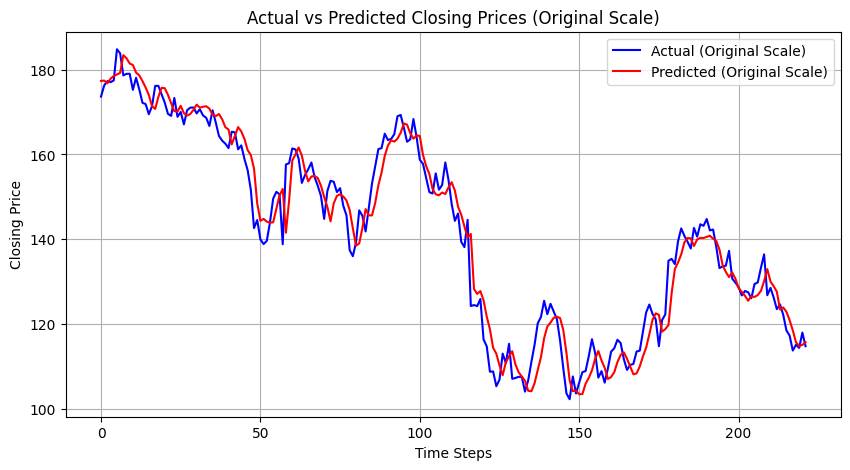

Epoch 1/250
44/44 [==============================] - 3s 24ms/step - loss: 0.0300 - val_loss: 5.9454e-04
Epoch 2/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0046 - val_loss: 0.0022
Epoch 3/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0043 - val_loss: 0.0022
Epoch 4/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0015 - val_loss: 1.6621e-04
Epoch 5/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0017 - val_loss: 5.4344e-04
Epoch 6/250
44/44 [==============================] - 1s 13ms/step - loss: 9.2290e-04 - val_loss: 1.0008e-04
Epoch 7/250
44/44 [==============================] - 1s 13ms/step - loss: 0.0011 - val_loss: 2.5001e-04
Epoch 8/250
44/44 [==============================] - 1s 14ms/step - loss: 7.6187e-04 - val_loss: 9.8102e-05
Epoch 9/250
44/44 [==============================] - 1s 13ms/step - loss: 8.6795e-04 - val_loss: 1.5703e-04
Epoch 10/250
44/44 [==============================] - 1s 13m

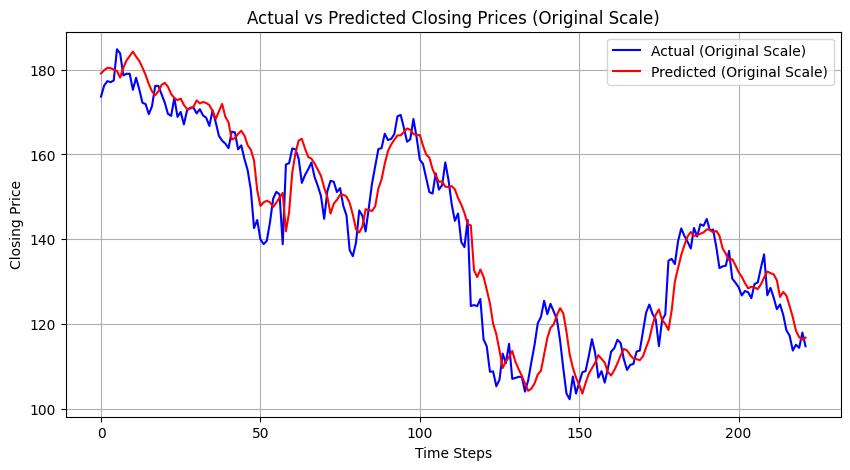

(4.396680350776188, 30.671027542553716, 5.505690930656767)

In [3]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Load the dataset
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)

# Ensure the dataset is sorted by company and time
data = data.sort_values(by=['Stock Name', 'Date'])

data.drop(columns=['Z_Score_Normalized','MA7','MA20', 'MACD', '20SD', 'EMA', 'logmomentum','lower_band','upper_band'])

print(data.columns)
# Fill missing values using forward and backward fill
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)

# Scale only the 'Close' column (target variable)
scaler_close = MinMaxScaler()
data['Close'] = scaler_close.fit_transform(data[['Close']])

# Identify numeric columns (excluding 'Stock Name' and 'Date')
numeric_columns = data.select_dtypes(include=[np.number]).columns

# Normalize the rest of the numeric features
scaler_features = MinMaxScaler()
data[numeric_columns] = scaler_features.fit_transform(data[numeric_columns])

# Split the data into training and testing
block_size = 252
test_start = block_size * 2  # Third block starts at 2 * block_size
test_end = block_size * 3    # Third block ends at 3 * block_size

test_data = data.iloc[test_start:test_end]  # Third block of 252 rows for testing
train_data = pd.concat([data.iloc[:test_start], data.iloc[test_end:]])  # All rows except the third block for training

# Group data by 'Stock Name'
train_data_grouped = train_data.groupby('Stock Name')
test_data_grouped = test_data.groupby('Stock Name')

# Prepare sequences for each stock
def create_sequences_per_stock(grouped_df, target_column, sequence_length=30):
    X, y = [], []
    for _, stock_data in grouped_df:
        stock_values = stock_data.drop(columns=['Stock Name', 'Date', target_column]).values
        target_values = stock_data[target_column].values
        for i in range(len(stock_data) - sequence_length):
            X.append(stock_values[i:i+sequence_length])
            y.append(target_values[i+sequence_length])
    return np.array(X), np.array(y)

sequence_length = 30  # 30-day sequences
X_train, y_train = create_sequences_per_stock(train_data_grouped, target_column='Close', sequence_length=sequence_length)
X_test, y_test = create_sequences_per_stock(test_data_grouped, target_column='Close', sequence_length=sequence_length)

# Function to execute the training and evaluation
def run_experiment():
    # Build the GRU model
    model = Sequential([
        GRU(64, activation='tanh', return_sequences=False, input_shape=(sequence_length, X_train.shape[2])),
        Dense(32, activation='relu'),
        Dense(1)
    ])

    model.compile(optimizer='adam', loss='mse')

    # Add Early Stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',     
        patience=50,            
        restore_best_weights=True
    )

    # Train the model
    epochs = 250
    batch_size = 32
    model.fit(
        X_train, y_train,
        shuffle=False,                
        validation_split=0.1,         
        epochs=epochs,
        batch_size=batch_size,
        verbose=1,
        callbacks=[early_stopping]
    )

    # Predictions
    predictions = model.predict(X_test)

    # Inverse scale the predictions and ground truth
    predictions_rescaled = scaler_close.inverse_transform(predictions)
    y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

    # Calculate evaluation metrics
    mae = mean_absolute_error(y_test_rescaled, predictions_rescaled)
    mse = mean_squared_error(y_test_rescaled, predictions_rescaled)
    rmse = np.sqrt(mse)

    # Plot predictions vs true values
    plt.figure(figsize=(10, 5))
    plt.plot(y_test_rescaled, label='Actual (Original Scale)', color='blue')
    plt.plot(predictions_rescaled, label='Predicted (Original Scale)', color='red')
    plt.title('Actual vs Predicted Closing Prices (Original Scale)')
    plt.xlabel('Time Steps')
    plt.ylabel('Closing Price')
    plt.legend()
    plt.grid()
    plt.show()
        
    return mae, mse, rmse

# Run the experiment 10 times and store results
results = [run_experiment() for _ in range(10)]

# Compute averages
avg_mae = np.mean([r[0] for r in results])
avg_mse = np.mean([r[1] for r in results])
avg_rmse = np.mean([r[2] for r in results])

# Print the averages
avg_mae, avg_mse, avg_rmse


In [ ]:
# Plot predictions vs true values (last 30 elements only)
plt.figure(figsize=(10, 5))
plt.plot(y_test_rescaled[-20:], label='Actual (Original Scale)', color='blue')
plt.plot(predictions_rescaled[-20:], label='Predicted (Original Scale)', color='red')
plt.title('Actual vs Predicted Closing Prices (Last 30 Elements)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid()
plt.show()


In [ ]:
!python -m pip install nltk


In [ ]:
!python -m pip install statsmodels


In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm

import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
#from keras.utils.vis_utils import plot_model
from pickle import load
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata

import warnings
warnings.filterwarnings("ignore")

# Ensure GPU is being used
def check_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("No GPU found. Using CPU instead.")
check_gpu()

stock_name = 'AMZN'
all_tweets = pd.read_csv('final_dataset_indexes.csv')
print(all_tweets.shape)
all_tweets.head()

In [ ]:
df = all_tweets[all_tweets['Stock Name'] == stock_name]
print(df.shape)
df.head()

In [ ]:
# Drop rows with at least one NaN value
df_clean = df.dropna()

# Display the number of rows before and after cleaning
print(f"Original number of rows: {len(df)}")
print(f"Number of rows after cleaning: {len(df_clean)}")


In [ ]:
dataset = df_clean
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
datetime_series = pd.to_datetime(dataset['Date'])
datetime_index = pd.DatetimeIndex(datetime_series.values)
dataset = dataset.set_index(datetime_index)
dataset = dataset.sort_values(by='Date')
dataset = dataset.drop(columns='Date')
dataset = dataset.drop(columns='Stock Name')

In [ ]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)

    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test
def predict_index(dataset, X_train, batch_size, prediction_period):

    # get the predict data (remove the in_steps days)
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
X_scale_dataset,y_scale_dataset = normalize_data(dataset, (-1,1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size = 5, predict_period = 1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
yc_train, yc_test, = split_train_test(yc)
index_train, index_test, = predict_index(dataset, X_train, 5, 1)

In [ ]:
input_dim = X_train.shape[1]
feature_size = X_train.shape[2]
output_dim = y_train.shape[1]

In [ ]:
# Build GRU-based generator
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(units=1024, return_sequences=True,
                            input_shape=(input_dim, feature_size), recurrent_dropout=0.3),
        tf.keras.layers.GRU(units=512, return_sequences=True, recurrent_dropout=0.3),
        tf.keras.layers.GRU(units=256, return_sequences=True, recurrent_dropout=0.3),
        tf.keras.layers.GRU(units=128, return_sequences=True, recurrent_dropout=0.3),
        tf.keras.layers.GRU(units=64, recurrent_dropout=0.3),
        tf.keras.layers.Dense(32, activation='relu'),
        tf.keras.layers.Dense(16, activation='relu'),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(units=output_dim)
    ])
    return model

In [ ]:
# Build discriminator model
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential([
        tf.keras.layers.Conv1D(8, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01),
                               input_shape=(input_dim + 1, 1)),
        tf.keras.layers.Conv1D(16, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(32, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(64, kernel_size=3, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Conv1D(128, kernel_size=1, strides=2, padding='same', activation=tf.keras.layers.LeakyReLU(alpha=0.01)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(220, activation=tf.keras.layers.LeakyReLU()),
        tf.keras.layers.Dense(220, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    return cnn_net


In [ ]:
# Define loss functions
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    return loss_f(tf.ones_like(fake_output), fake_output)

In [ ]:
def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
def train(real_x, real_y, yc, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price)

        #Save model every X checkpoints
        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock_name}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock_name}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())

        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)

    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.subplot(2,1,1)
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Discriminator Loss')
    plt.legend()

    plt.subplot(2,1,2)
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#000000')
    plt.xlabel('Epoch')
    plt.ylabel('Generator Loss')
    plt.legend()

    plt.show()

    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

def plot_test_data(Real_test_price, Predicted_test_price, index_test):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)

    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)

    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)

    plt.figure(figsize=(12, 6))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock_name}", fontsize=20)
    plt.show()

In [ ]:
learning_rate = 5e-4
epochs = 500
output_dim = 1

g_optimizer = tf.keras.optimizers.Adam(learning_rate)
d_optimizer = tf.keras.optimizers.Adam(learning_rate)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
discriminator = make_discriminator_model(X_train.shape[1])

In [ ]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [ ]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')

In [ ]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test)

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import GRU, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
​
# Ensure GPU is being used
def check_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        print(f"GPU(s) available: {[gpu.name for gpu in gpus]}")
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    else:
        print("No GPU found. Using CPU instead.")
​
check_gpu()
​
# Load and preprocess data
data_path = "final_dataset_indexes.csv"
data = pd.read_csv(data_path)
data = data.sort_values(by=['Stock Name', 'Date'])
data.fillna(method="ffill", inplace=True)
data.fillna(method="bfill", inplace=True)
​
# Scale data using MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
numeric_columns = data.select_dtypes(include=[np.number]).columns
data[numeric_columns] = scaler.fit_transform(data[numeric_columns])
​
# Parameters
sequence_length = 30
input_dim = len(numeric_columns)  # Number of features
latent_dim = 100  # Dimensionality of the random noise for generator
​
# Split data
train_data = data.iloc[:-252]  # Train on all except the last 252 rows
test_data = data.iloc[-252:]  # Last 252 rows for testing
​
def create_sequences(df, sequence_length):
    sequences = []
    for i in range(len(df) - sequence_length):
        sequences.append(df.iloc[i:i+sequence_length].values)
    return np.array(sequences)
​
# Prepare training and testing sequences
train_sequences = create_sequences(train_data[numeric_columns], sequence_length=sequence_length)
test_sequences = create_sequences(test_data[numeric_columns], sequence_length=sequence_length)
​
def create_targets(df, sequence_length, target_column):
    return df[target_column].values[sequence_length:]
​
target_column = 'Close'
test_targets = create_targets(test_data, sequence_length, target_column)
​
# Build Generator
def build_generator(sequence_length, input_dim, latent_dim):
    generator = Sequential([
        GRU(128, activation='tanh', return_sequences=True, input_shape=(sequence_length, latent_dim)),
        GRU(128, activation='tanh', return_sequences=True),
        GRU(64, activation='tanh', return_sequences=True),
        GRU(64, activation='tanh', return_sequences=True),
        GRU(input_dim, activation='tanh', return_sequences=True)
    ])
    return generator
​
# Build Discriminator
def build_discriminator(sequence_length, input_dim):
    discriminator = Sequential([
        Flatten(input_shape=(sequence_length, input_dim)),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(1, activation='sigmoid')  # Probability output
    ])
    return discriminator
​
# Initialize generator and discriminator
generator = build_generator(sequence_length, input_dim, latent_dim)
discriminator = build_discriminator(sequence_length, input_dim)
​
discriminator.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
​
def build_gan(generator, discriminator):
    discriminator.trainable = False
    gan_input = Input(shape=(sequence_length, latent_dim))
    generated_sequence = generator(gan_input)
    gan_output = discriminator(generated_sequence)
    gan = Model(gan_input, gan_output)
    gan.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy')
    return gan
​
gan = build_gan(generator, discriminator)
​
# Training loop
batch_size = 64
epochs = 50
steps_per_epoch = len(train_sequences) // batch_size
​
for epoch in range(epochs):
    for step in range(steps_per_epoch):
        # Train discriminator
        noise = np.random.normal(0, 1, size=(batch_size, sequence_length, latent_dim))
        fake_sequences = generator.predict(noise)
        real_sequences = train_sequences[np.random.randint(0, train_sequences.shape[0], batch_size)]
​
        real_labels = np.ones((batch_size, 1))
        fake_labels = np.zeros((batch_size, 1))
​
        d_loss_real = discriminator.train_on_batch(real_sequences, real_labels)
        d_loss_fake = discriminator.train_on_batch(fake_sequences, fake_labels)
        d_loss = 0.5 * (d_loss_real + d_loss_fake)
​
        # Train generator
        noise = np.random.normal(0, 1, size=(batch_size, sequence_length, latent_dim))
        g_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
​
    print(f"Epoch {epoch + 1}/{epochs} | D Loss: {d_loss:.4f} | G Loss: {g_loss:.4f}")
​
# Generate synthetic sequences for evaluation
noise = np.random.normal(0, 1, size=(test_sequences.shape[0], sequence_length, latent_dim))
predicted_sequences = generator.predict(noise)
​
# Extract the 'Close' column index
close_index = numeric_columns.get_loc(target_column)
​
# Inverse scaling for real values
test_targets_rescaled = scaler.inverse_transform(test_data[numeric_columns])[:, close_index]
​
# Inverse scaling for predicted values
padded_predictions = np.pad(
    predicted_sequences[:, -1, :],  # Use the last step of each sequence
    ((0, 0), (0, len(numeric_columns) - predicted_sequences.shape[2])),  # Pad columns
    mode='constant',
    constant_values=0
)
predicted_values_rescaled = scaler.inverse_transform(padded_predictions)[:, close_index]
​
# Plot real vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(test_targets_rescaled, label='Real', color='blue')
plt.plot(predicted_values_rescaled, label='Predicted', color='red')
plt.title('Real vs Predicted Values (Last Stock)')
plt.xlabel('Time Steps')
plt.ylabel('Closing Price')
plt.legend()
plt.grid(True)
plt.show()